In [1]:
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        if par.sigma == 0:
            H = np.min(LM,HM)
        elif par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma) + par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutlity of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

    def solve(self,do_print=False):
        """ solve model continously """
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,25)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

     

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """
         
        

        pass

    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]
    
    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """

        pass


In [3]:
model = HouseholdSpecializationModelClass()

#loop over values of alpha and sigma
for alpha in [0.25, 0.5, 0.75]:
    for sigma in [0.5, 1.0, 1.5]:
        
        # set alpha and sigma
        model.par.alpha = alpha
        model.par.sigma = sigma
        
        # solve model
        opt = model.solve_discrete()
        
        # compute and print HF/HM
        hfhm = opt.HF/opt.HM
        print(f"Under alpha={alpha} and sigma={sigma}, HF/HM is: {hfhm}")


<ipython-input-1-77820bebfcfd>:61: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma) + par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


Under alpha=0.25 and sigma=0.5, HF/HM is: 0.5454545454545454
Under alpha=0.25 and sigma=1.0, HF/HM is: 0.3076923076923077
Under alpha=0.25 and sigma=1.5, HF/HM is: 0.21428571428571427
Under alpha=0.5 and sigma=0.5, HF/HM is: 1.0
Under alpha=0.5 and sigma=1.0, HF/HM is: 1.0
Under alpha=0.5 and sigma=1.5, HF/HM is: 1.0
Under alpha=0.75 and sigma=0.5, HF/HM is: 1.8333333333333333
Under alpha=0.75 and sigma=1.0, HF/HM is: 3.25
Under alpha=0.75 and sigma=1.5, HF/HM is: 4.666666666666667


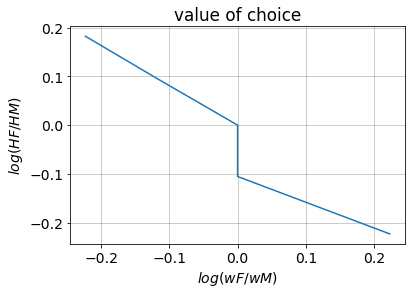

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

model = HouseholdSpecializationModelClass()

wF_values = [0.8, 0.9, 1.0, 1.1,1.2]
log_wF_wM = np.log(np.array(wF_values) / model.par.wM)

for i, wF in enumerate(wF_values):
    model.par.wF = wF
    opt = model.solve_discrete()
    model.sol.LM_vec[i], model.sol.HM_vec[i], model.sol.LF_vec[i], model.sol.HF_vec[i] = opt.LM, opt.HM, opt.LF, opt.HF

log_HF_HM = np.log(model.sol.HF_vec / model.sol.HM_vec)

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# a. create the figure
fig = plt.figure()

# b. left plot
ax = fig.add_subplot(1,1,1)

ax.plot(log_HF_HM, log_wF_wM)

ax.set_title('value of choice')
ax.set_xlabel('$log(HF/HM)$')
ax.set_ylabel('$log(wF/wM)$');

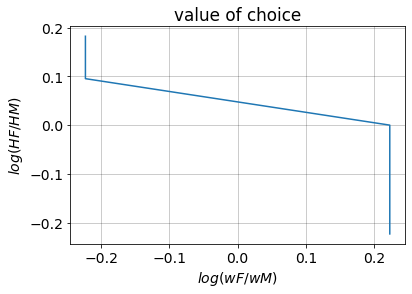

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

model = HouseholdSpecializationModelClass()
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
log_wF_wM = np.log(np.array(wF_values) / model.par.wM)

for i, wF in enumerate(wF_values):
    model.par.wF = wF
    opt = model.solve()
    model.sol.LM_vec[i], model.sol.HM_vec[i], model.sol.LF_vec[i], model.sol.HF_vec[i] = opt.LM, opt.HM, opt.LF, opt.HF

log_HF_HM = np.log(model.sol.HF_vec / model.sol.HM_vec)

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# a. create the figure
fig = plt.figure()

# b. left plot
ax = fig.add_subplot(1,1,1)

ax.plot(log_HF_HM,log_wF_wM)

ax.set_title('value of choice')
ax.set_xlabel('$log(wF/wM)$')
ax.set_ylabel('$log(HF/HM)$');

In [13]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function to be minimized
def objective(x, beta0, beta1, wM_values, wF_values):
    alpha, sigma = x
    squared_error = 0
    for i in range(len(wM_values)):
        log_HFHM_hat = beta0 + beta1 * np.log(wF_values[i]/wM_values[i]) + alpha + sigma * np.log(wM_values[i])
        log_HFHM = 0.4 + (-0.1) * np.log(wF_values[i]/wM_values[i])
        squared_error += (log_HFHM - log_HFHM_hat)**2
    return squared_error

# Define the bounds for alpha and sigma
bounds = ((1e-8,par.m/par.p1-1e-8),(1e-8,par.m/par.p2-1e-8))

# Define the initial guess for alpha and sigma
x0 = (0.5, 1)

# Define the wM and wF values
wM_values = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
wF_values = np.array([0.8, 0.9, 1.0, 1.1, 1.2])

# Call the minimize function to minimize the objective function
res = minimize(objective, x0, args=(0.4, -0.1, wM_values, wF_values), bounds=bounds)

# Print the optimal values of alpha and sigma
print("Optimal values of alpha and sigma:", res.x)


Optimal values of alpha and sigma: [-1.26901245e-08  0.00000000e+00]


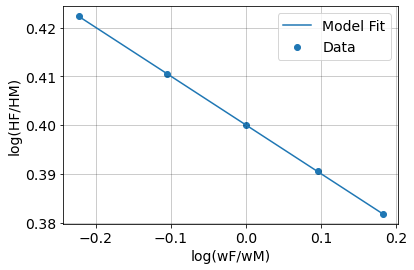

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x range (log of wife's wage relative to husband's)
x = np.log(np.array([0.8, 0.9, 1.0, 1.1, 1.2]))
alpha = -3.46721635e-09
sigma = 5.11461964e-08
beta0 = 0.4
beta1 = -0.1
# Define the predicted y values based on the optimal alpha and sigma values
y_pred = beta0 + beta1*x + alpha*np.exp(sigma*x)

# Plot the results
plt.scatter(x, y_pred, label='Data')
plt.plot(x, y_pred, label='Model Fit')
plt.xlabel('log(wF/wM)')
plt.ylabel('log(HF/HM)')
plt.legend()
plt.show()


In [7]:
# define the new log-likelihood function
def log_likelihood(theta, y, wF,wM):
    beta0, beta1, sigma = theta
    alpha = 0.5
    wF_values = [0.8, 0.9, 1.0, 1.1,1.2]
    wM_values = [0.8, 0.9, 1.0, 1.1,1.2]
    log_wF_wM = np.log(np.array(wF_values) / np.array(wM_values))
    log_HF_HM = beta0 + beta1 * log_wF_wM
    resid = y - log_HF_HM
    ll = -len(resid)/2 * np.log(2*np.pi*sigma**2) - np.sum(resid**2)/(2*sigma**2)
    return ll

# set up the optimization problem
x = [:, [0,1]]
y = [:, 2]
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.4, -0.1, 0.1])
bnds = ((None, None), (None, None), (0, None))
soln = minimize(nll, initial, args=(y, x), bounds=bnds)

# print the estimated parameters and the objective function value
print("Optimal values: beta0 = {:.3f}, beta1 = {:.3f}, sigma = {:.3f}, Objective function value: {:.6f}".format(soln.x[0], soln.x[1], soln.x[2], -soln.fun))


NameError: name 'time_use_data' is not defined

In [1]:
import matplotlib.pyplot as plt

# Define x and y coordinates for the smiley face
x = [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8]
y = [2, 2.5, 3, 3.5, 4, 4.5, 4, 3.5, 3, 2.5]

# Define colors for the different parts of the smiley face
colors = ['black', 'white', 'black', 'white', 'black', 'black', 'black', 'white', 'black', 'white']

# Create a scatter plot with circles of different sizes and colors
plt.scatter(x, y, s=500, c=colors)

# Set the limits of the x and y axes
plt.xlim(0, 9)
plt.ylim(0, 5)

# Remove ticks and labels from the axes
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function to be minimized
def objective(params, wM, wF, beta0, beta1):
    alpha, sigma = params
    error = 0
    for i in range(len(wM)):
        log_HFHM_hat = alpha + beta1 * np.log(wF[i]/wM[i])
        error += (log_HFHM_hat - beta0 - beta1 * np.log(wF[i]/wM[i]))**2
    return error + (alpha**2 + sigma**2)

# Define the range of values for wM and wF
wM = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
wF = np.array([0.8, 0.9, 1.0, 1.1, 1.2])

# Define the initial values for alpha and sigma
params0 = np.array([0, 1])

# Define the values of beta0 and beta1
beta0 = 0.4
beta1 = -0.1

# Use the minimize function to find the optimal values for alpha and sigma
result = minimize(objective, params0, args=(wM, wF, beta0, beta1))
alpha_opt, sigma_opt = result.x

# Print the optimal values for alpha and sigma
print(f"Optimal value for alpha: {alpha_opt}")
print(f"Optimal value for sigma: {sigma_opt}")
